# CoCoScore Implementation

This notebook consists of implementing the [CoCoScore](https://www.biorxiv.org/content/10.1101/444398v1) literature model for comparison.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import re
import sys

sys.path.append(os.path.abspath('../../../../modules'))

import operator
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.rnn_base import mark_sentence
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

from metal.analysis import lf_summary
from metal.label_model import LabelModel
from metal.utils import plusminus_to_categorical

from gensim.models import FastText
from gensim.models import KeyedVectors

from utils.notebook_utils.label_matrix_helper import label_candidates, get_auc_significant_stats
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, generate_results_df
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap

In [4]:
CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])

In [5]:
quick_load = True

In [6]:
total_candidates_df = pd.read_table("../../dataset_statistics/data/all_cbg_candidates.tsv.xz")
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DB00117,L-Histidine,NaN,0,1,1,0.37753,6,1.0,0.0,10.0,94389805,"Thus, as the assessment of protein glycosylati...",114,33517095
1,1,A1BG,DB00143,Glutathione,NaN,0,1,1,0.30352,6,1.0,1.0,2.0,83523801,Similar observations were made in T98 glioma c...,34,28913100


In [7]:
spreadsheet_names = {
    'dev': '../../data/sentences/sentence_labels_dev.xlsx',
    'test': '../../data/sentences/sentence_labels_test.xlsx'
}

In [8]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_cbg")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [9]:
distant_supervision_marginals = pd.read_table("../../label_sampling_experiment/results/CbG/marginals/baseline_marginals.tsv.xz")
distant_supervision_marginals.head(2)

,pos_class_marginals,neg_class_marginals,candidate_id
0,0.01000,0.99000,50493
1,0.00028,0.99972,50500


In [10]:
all_embedded_cg_df = pd.read_table("../../word_vector_experiment/results/all_embedded_cg_sentences.tsv.xz")
all_embedded_cg_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,candidate_id,sen_length
0,333.0,3.0,191.0,6.0,161.0,129.0,244.0,33.0,2032.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50493,17
1,16.0,523.0,15.0,645.0,12.0,527.0,154.0,27.0,33.0,36294.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50494,27


In [11]:
word_vectors = pd.read_csv(
    "../../word_vector_experiment/results/compound_binds_gene_word_vectors.bin",
    sep=" ", skiprows=1, 
    header=None, index_col=0, 
    keep_default_na=False
)
word_vectors.head(2)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
",",-0.102467,-0.182303,-0.154361,-0.021046,0.048865,-0.143712,-0.153429,0.055876,-0.018329,0.115706,...,0.006308,-0.132545,0.034875,0.118763,0.041083,0.215425,-0.057115,0.152732,-0.124555,-0.074304
),-0.139569,0.011818,0.075041,0.049088,0.026197,0.074661,-0.016193,0.010679,0.195021,-0.072605,...,0.282162,0.012230,-0.116063,0.090987,-0.173898,0.010089,-0.023298,0.195740,-0.259889,-0.052515


In [12]:
word_dict = pd.read_table("../../word_vector_experiment/results/compound_binds_gene_word_dict.tsv", keep_default_na=False)
reverse_word_dict = dict(zip(word_dict.index, word_dict.word))
word_dict = dict(zip(word_dict.word, word_dict.index))

In [13]:
total_training_sentences_df = (
    all_embedded_cg_df.merge(
        distant_supervision_marginals
        .assign(labels=lambda x: x.pos_class_marginals > 0.5)
        [["labels", "candidate_id"]]
        .astype({"labels":int}),
        on="candidate_id"
    )
)
total_training_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,candidate_id,sen_length,labels
0,333.0,3.0,191.0,6.0,161.0,129.0,244.0,33.0,2032.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50493,17,0
1,663.0,888.0,53.0,33.0,3011.0,35.0,19.0,3.0,2816.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50500,19,0


In [14]:
total_dev_sentences_df = (
    all_embedded_cg_df.merge(
        candidate_dfs['dev']
        [["curated_cbg", "candidate_id"]],
        on="candidate_id"
    )
)
total_dev_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,candidate_id,sen_length,curated_cbg
0,16.0,523.0,15.0,1257.0,19.0,2.0,1434.0,5.0,96364.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50527,38,0.0
1,16.0,388.0,161.0,129.0,389.0,390.0,7.0,391.0,392.0,393.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51441,34,0.0


In [15]:
total_test_sentences_df = (
    all_embedded_cg_df.merge(
        candidate_dfs['test']
        [["curated_cbg", "candidate_id"]],
        on="candidate_id"
    )
)
total_test_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,candidate_id,sen_length,curated_cbg
0,16.0,20758.0,19.0,67821.0,19.0,27.0,119.0,823.0,15.0,10408.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50759,36,0.0
1,51.0,292.0,3569.0,129.0,186648.0,184.0,51.0,16.0,11329.0,6428.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51021,56,0.0


In [16]:
def create_data_matrix(query_df, filename="sentences.txt"):
    search_regex = rf'(\b{word_dict["~~[[2"]}\b.+\b{word_dict["2]]~~"]}\b,)'
    search_regex += rf'|(\b{word_dict["~~[[1"]}\b.+\b{word_dict["1]]~~"]}\b,)'
    
    print(search_regex)
    data = []
    with open(filename, "w") as g:
        for index, row in tqdm_notebook(query_df.iterrows()):
            cand_str = ",".join(map(str, row.dropna().astype(int).values))
            pruned_str = re.sub(search_regex, "", cand_str)
            values = list(map(int, pruned_str.split(",")))
            g.write(f"__label__{values[-1]}\t")
            g.write("\t".join([reverse_word_dict[val] for val in values[:-2]]))
            g.write("\n")

In [17]:
query_df = (
    total_training_sentences_df
    [[col for col in total_training_sentences_df.columns if col not in ["sen_length"]]]
)
training_matrix = create_data_matrix(query_df, filename="training.txt")

(\b3\b.+\b6\b,)|(\b33\b.+\b35\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [18]:
query_df = (
    total_dev_sentences_df
    .drop_duplicates()
    [[col for col in total_dev_sentences_df.columns if col not in ["sen_length"]]]
)
dev_matrix = create_data_matrix(query_df, filename="dev.txt")

(\b3\b.+\b6\b,)|(\b33\b.+\b35\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [19]:
query_df = (
    total_test_sentences_df
    .drop_duplicates()
    [[col for col in total_test_sentences_df.columns if col not in ["sen_length"]]]
)
test_matrix = create_data_matrix(query_df, filename="test.txt")

(\b3\b.+\b6\b,)|(\b33\b.+\b35\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [20]:
os.system("../../../../../fastText/fasttext supervised -input training.txt -output cbg_model -lr 0.005 -epoch 50 -dim 300 -wordNgrams 2")
os.system("../../../../../fastText/fasttext predict-prob cbg_model.bin dev.txt > dev_predictions.tsv")
os.system("../../../../../fastText/fasttext predict-prob cbg_model.bin test.txt > test_predictions.tsv")

0

In [21]:
precision, recall, _ = precision_recall_curve(
    total_dev_sentences_df.curated_cbg,
    pd.read_table('dev_predictions.tsv', header=None, sep=" ")[1]
)
auc(recall, precision)

0.07747084559716666

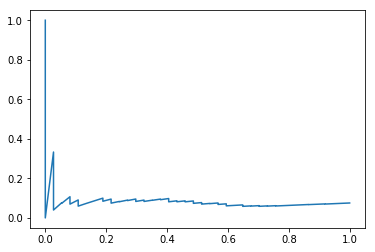

In [22]:
plt.plot(recall, precision)

In [23]:
fpr, tpr, _ = roc_curve(
    total_dev_sentences_df.curated_cbg,
    pd.read_table('dev_predictions.tsv', header=None, sep=" ")[1]
)
auc(fpr, tpr)

0.4718930593660615

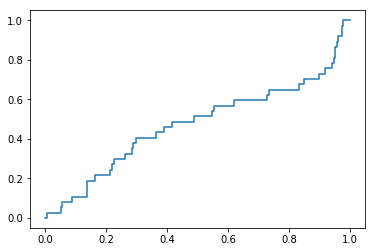

In [24]:
plt.plot(fpr, tpr)

In [25]:
query_df = (
    all_embedded_cg_df
    .assign(labels=0)
    [[col for col in all_embedded_cg_df.columns if col not in ["sen_length"]]]
)
create_data_matrix(query_df, filename="all_cg_sentences.txt")

(\b3\b.+\b6\b,)|(\b33\b.+\b35\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [26]:
os.system("../../../../../fastText/fasttext predict-prob cbg_model.bin all_cg_sentences.txt > all_cg_sentences_predictions.tsv")

0

In [29]:
predictions_df = pd.read_table("all_cg_sentences_predictions.tsv", header=None, names=["label", "predictions"], sep=" ")
predictions_df['candidate_id'] = all_embedded_cg_df.candidate_id.values
predictions_df.head(2)

,label,predictions,candidate_id
0,__label__0,0.999841,50493
1,__label__0,0.997750,50494


In [30]:
final_pred_df = (
    total_candidates_df
    [["entrez_gene_id", "drugbank_id", "candidate_id"]]
    .merge(predictions_df[["predictions", "candidate_id"]])
)
final_pred_df.head(2)

,entrez_gene_id,drugbank_id,candidate_id,predictions
0,1,DB00143,28913100,0.836518
1,1,DB00145,33537346,0.980302


In [31]:
added_scores_df = (
    final_pred_df
    .groupby(["entrez_gene_id", "drugbank_id"])
    .aggregate({"predictions": 'sum'})
    .reset_index()
)
added_scores_df.head(2)

,entrez_gene_id,drugbank_id,predictions
0,1,DB00143,0.836518
1,1,DB00145,0.980302


In [32]:
total_score = added_scores_df.predictions.sum()
gene_scores = added_scores_df.groupby("entrez_gene_id").agg({"predictions":"sum"}).reset_index()
gene_scores = dict(zip(gene_scores.entrez_gene_id, gene_scores.predictions))
drug_scores = added_scores_df.groupby("drugbank_id").agg({"predictions":"sum"}).reset_index()
drug_scores = dict(zip(drug_scores.drugbank_id, drug_scores.predictions))

alpha=0.65

final_scores_df = added_scores_df.assign(
    final_score=(
        added_scores_df.apply(
            lambda x: pd.np.exp(
                    alpha*pd.np.log(x['predictions']) + (1-alpha)*(
                    pd.np.log(x['predictions']) + pd.np.log(total_score) - 
                    pd.np.log(gene_scores[x['entrez_gene_id']]) - pd.np.log(drug_scores[x['drugbank_id']])
                )
            ), 
            axis=1
        )
    )
)
final_scores_df.head(2)

,entrez_gene_id,drugbank_id,predictions,final_score
0,1,DB00143,0.836518,0.895084
1,1,DB00145,0.980302,4.990157


In [33]:
score_with_labels_df = (
    final_scores_df
    .merge(
        total_candidates_df[["drugbank_id", "entrez_gene_id", "hetionet"]],
        on=["drugbank_id", "entrez_gene_id"]
    )
    .drop_duplicates()
)
score_with_labels_df.head(2)

,entrez_gene_id,drugbank_id,predictions,final_score,hetionet
0,1,DB00143,0.836518,0.895084,0
1,1,DB00145,0.980302,4.990157,0


In [34]:
score_with_labels_df.drop("predictions", axis=1).to_csv("cd_edge_prediction_cocoscore.tsv", sep="\t", index=False)

In [35]:
fpr, tpr, _ = roc_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(recall, precision))

0.7362928924514378
0.11025872275984427
